In [2]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import pi

%matplotlib inline

## Scraping web pages for raw data

In [132]:
#define strings to be attached to the URL to control the query

####save for other cases####
#min_type = 'min_type=itp'#key word for citable documents
#min_doc = 'min=50'#show countries with at least 50 citable documents for the selected year

yr = ['year='+str(yr) for yr in range(1996,2017)]
ar = ['area='+str(ar)+'00' for ar in range(10,37)]#area code has a range of 1000 to 3700

In [175]:
#scrape the raw data from the web

deposit = pd.DataFrame()
for year in yr:
    for area in ar:
        url = 'http://www.scimagojr.com/countryrank.php?'+year+'&'+area
        with requests.Session() as session:
            buffer = []
            session.headers['content-type'] = 'application/json'
            response = session.get(url)
            soup = BeautifulSoup(response.content, "lxml")
            for mytable in soup.find_all('tbody'):
                for trs in mytable.find_all('tr'):
                    tds = trs.find_all('td')
                    row = [elem.text.strip() for elem in tds]
                    buffer.append(row)
            buffer = pd.DataFrame(buffer)
            buffer.drop(buffer.columns[1], axis=1, inplace = True)
            buffer.insert(0,'Year', [year[-4:]]*len(buffer))
            buffer.insert(0,'Area', [area[-4:]]*len(buffer))
        deposit = deposit.append(buffer)

C:\Users\Li\Anaconda3\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file C:\Users\Li\Anaconda3\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


In [176]:
#final touch-up and export the result to a csv file
deposit.drop(0,axis=1,inplace = True)
deposit.to_csv('SciPubData.csv')

In [135]:
#scrape the web page and create a global dataset stratified by areas but aggregated over the two decades
deposit = pd.DataFrame()
for area in ar:
    url = 'http://www.scimagojr.com/countryrank.php?'+area
    with requests.Session() as session:
        buffer = []
        session.headers['content-type'] = 'application/json'
        response = session.get(url)
        soup = BeautifulSoup(response.contentm, "lxml")
        for mytable in soup.find_all('tbody'):
            for trs in mytable.find_all('tr'):
                tds = trs.find_all('td')
                row = [elem.text.strip() for elem in tds]
                buffer.append(row)
        buffer = pd.DataFrame(buffer)
        buffer.drop(buffer.columns[1], axis=1, inplace = True)
        buffer.insert(0,'Area', [area[-4:]]*len(buffer))
    deposit = deposit.append(buffer)

C:\Users\Li\Anaconda3\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file C:\Users\Li\Anaconda3\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


In [136]:
deposit.drop(0,axis=1,inplace = True)
deposit.to_csv('SciPubData_global.csv')

## Data Mining

In [3]:
#further cleanning the datasets and properly name the columns
SciPub = pd.read_csv('SciPubData.csv',encoding='latin-1')
SciPub.drop('Unnamed: 0',axis=1,inplace=True)

SciPub_Global = pd.read_csv('SciPubData_global.csv',encoding='latin-1')
SciPub_Global.drop('Unnamed: 0',axis=1,inplace=True)

SciPub_total = pd.read_csv('SciPubData_all.csv',encoding='latin-1')

SciPub.columns = ['Area','Year','Country','Documents','Citable Documents','Citations','Self-citations','Citation per Documents','H Index']
SciPub_Global.columns = ['Area','Country','Documents','Citable Documents','Citations','Self-citations','Citation per Documents','H Index']

In [4]:
SciPub = SciPub.set_index(['Area','Year','Country'])
SciPub.head()

Documents  Citable Documents  Citations  \
Area Year Country                                                   
1000 1996 United States        4649               4140     859154   
          China                 769                766       6444   
          United Kingdom        714                594     108112   
          Germany               558                528      95304   
          India                 463                457       5480   

                          Self-citations  Citation per Documents  H Index  
Area Year Country                                                          
1000 1996 United States           429776                  184.80     1200  
          China                     2952                    8.38      316  
          United Kingdom           18956                  151.42      660  
          Germany                  17271                  170.80      586  
          India                     2772                   11.84      165

### A overview of research and publication activities of the world

Globally, what is the "hottest" area in terms of the research endeavors and publications?

In [5]:
#set up a dictionary for the lookup of area code and area name
area_dict = {1000:'Multidisciplinary',1100:'Agricultural and Biological Sciences',1200:'Arts and Humanities',1300:'Biochemistry, Genetics and Molecular Biology',
            1400:'Buisness, Management and Accounting',1500:'Chemical Engineering',1600:'Chemistry',
            1700:'Computer Science',1800:'Decision Sciences',1900:'Earth and Planetary Sciences',
            2000:'Economics, Econometrics and Finance',2100:'Energy',2200:'Engineering',2300:'Environmental Science',2400:'Immunology and Microbiology',2500:'Materials Science',
            2600:'Mathematics',2700:'Medicine',2800:'Neuroscience',2900:'Nursing',
            3000:'Pharmacology, Toxicology and Pharmaceutics',3100:'Physics and Astronomy',3200:'Psychology',
            3300:'Social Science',3400:'Veterinary',3500:'Dentistry',3600:'Health Professions'}

In [6]:
#define a function that calculates the subtotal of publications within an area and plot the pattern
def subplot(dataset,index,value):
    sub = pd.pivot_table(dataset, values=[value], index=[index], aggfunc=np.sum)
    sub.sort_values(by=value,ascending=False,inplace=True)


    fig, ax = plt.subplots()
    pos = np.arange(len(area_dict))
    fig.set_size_inches(10,15)
    ax.barh(pos,sub[value], align='center')
    ax.set_yticks(pos)
    ax.set_yticklabels([area_dict[k] for k in list(sub.index)],fontsize=14)
    ax.invert_yaxis()
    ax.set_xlabel('Number of documents',fontsize=14)
    ax.set_title('World Publication by Area',fontsize=18)
    #plt.savefig('WorldPubs.png')
    plt.show()

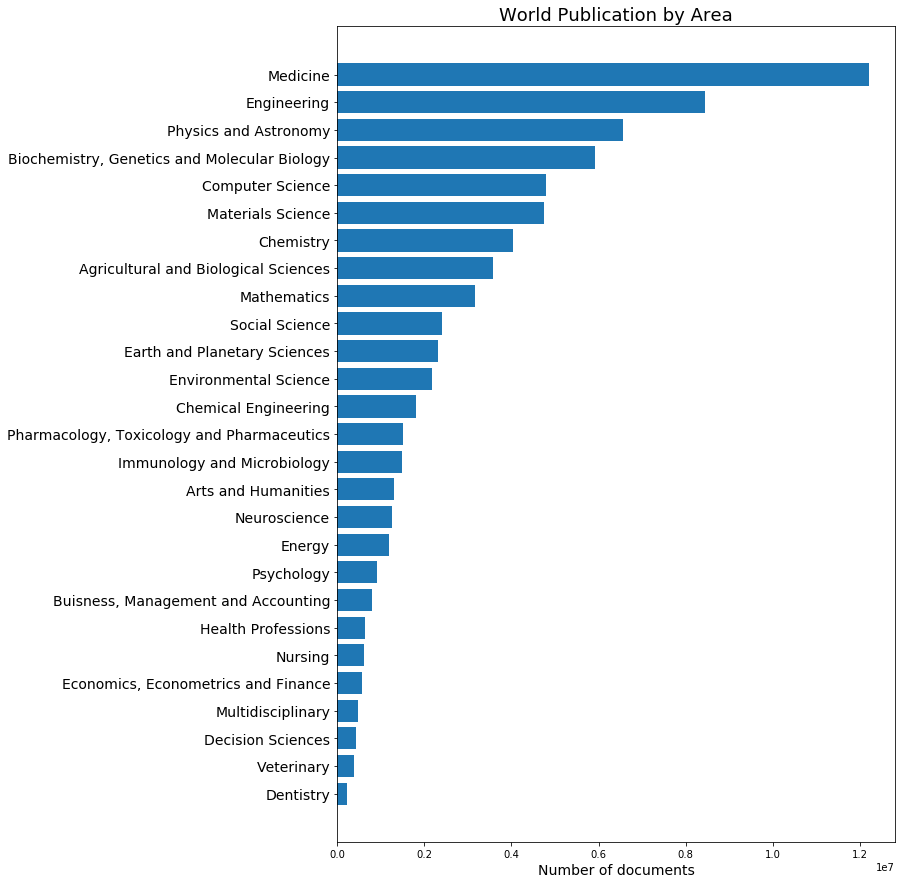

In [7]:
subplot(SciPub_Global,'Area','Documents')

How about ranking by total number of H-Index?

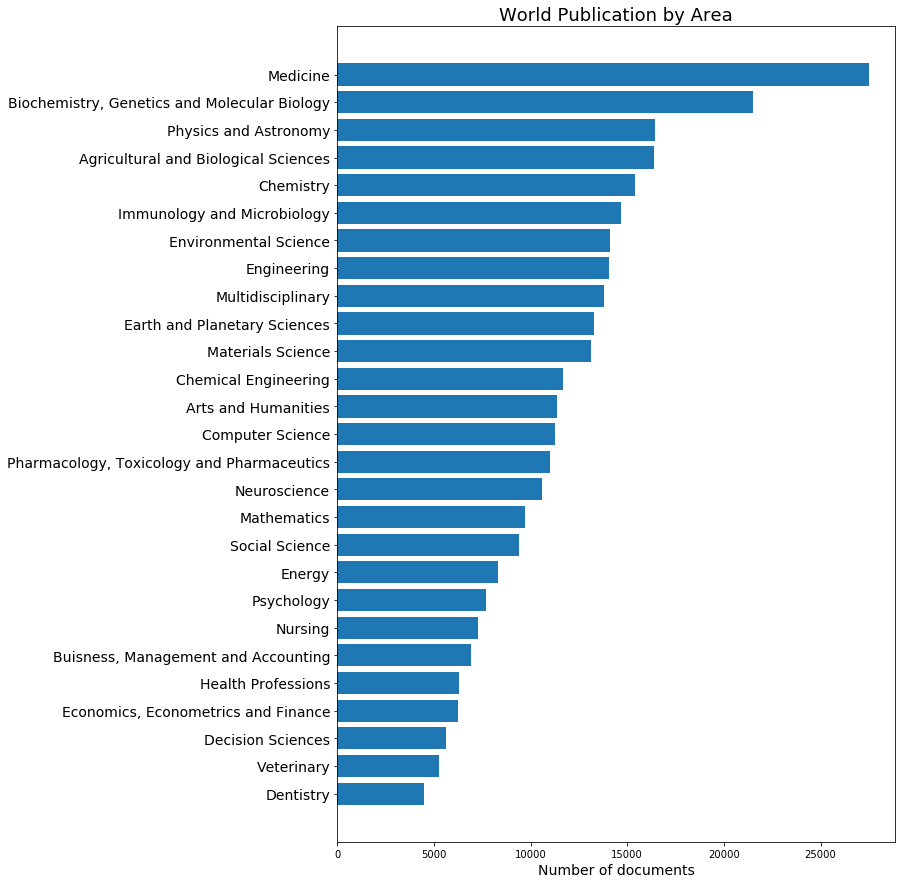

In [8]:
subplot(SciPub_Global,'Area','H Index')

Has this pattern changed over the two decades?

In [9]:
#subset the master dataset into two based on the two decades
SciPub_buff = SciPub.reset_index()
SciPub_buff_dec1 = SciPub_buff.loc[SciPub_buff['Year']<=2006]
SciPub_buff_dec2 = SciPub_buff.loc[SciPub_buff['Year'] > 2006]

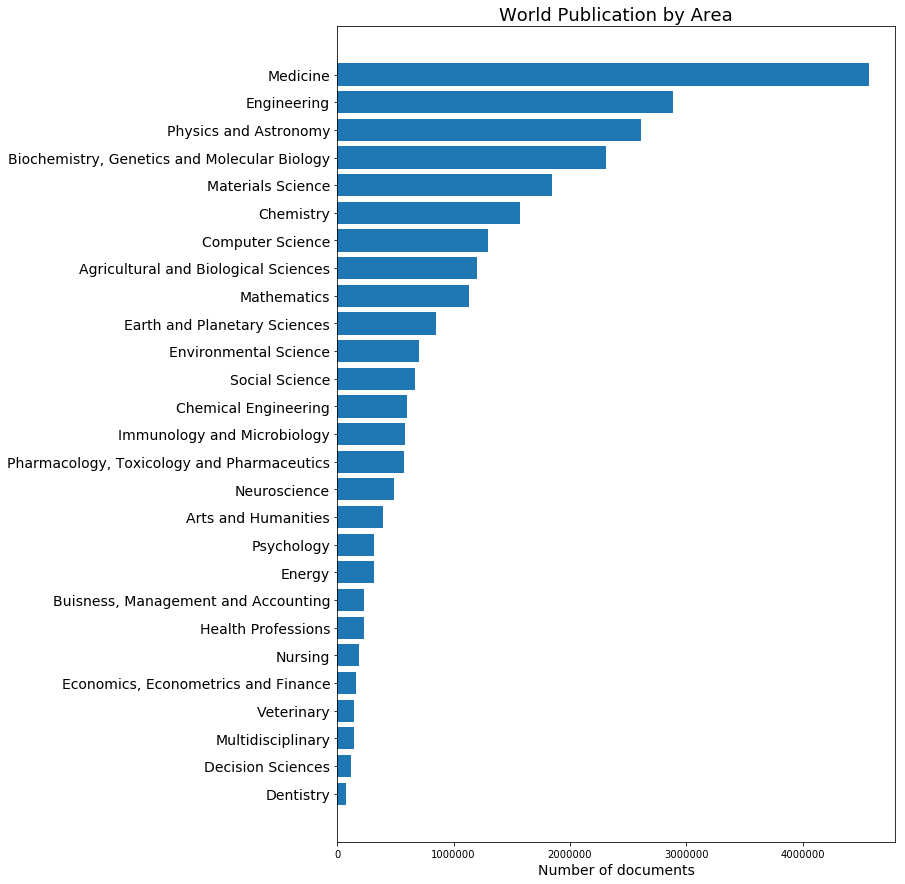

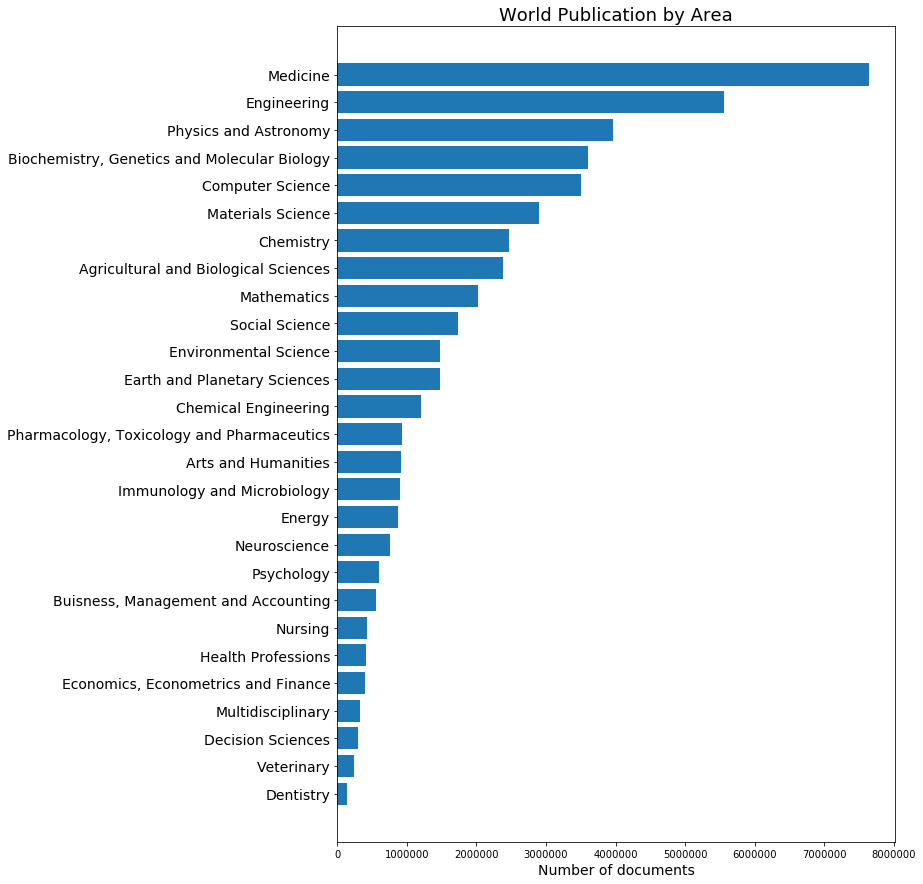

In [10]:
subplot(SciPub_buff_dec1,'Area','Documents')
subplot(SciPub_buff_dec2,'Area','Documents')

More specifically, has the pattern changed from 1996 to 2016 (two single years)? We should expect to see some more dramatic changes.

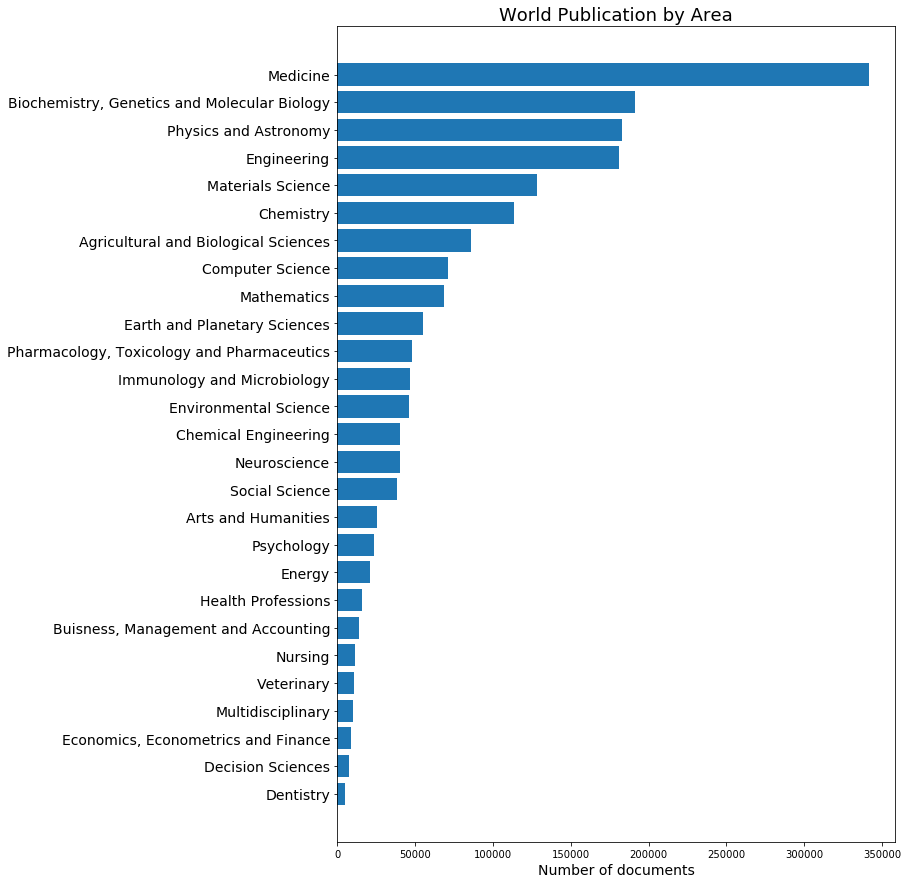

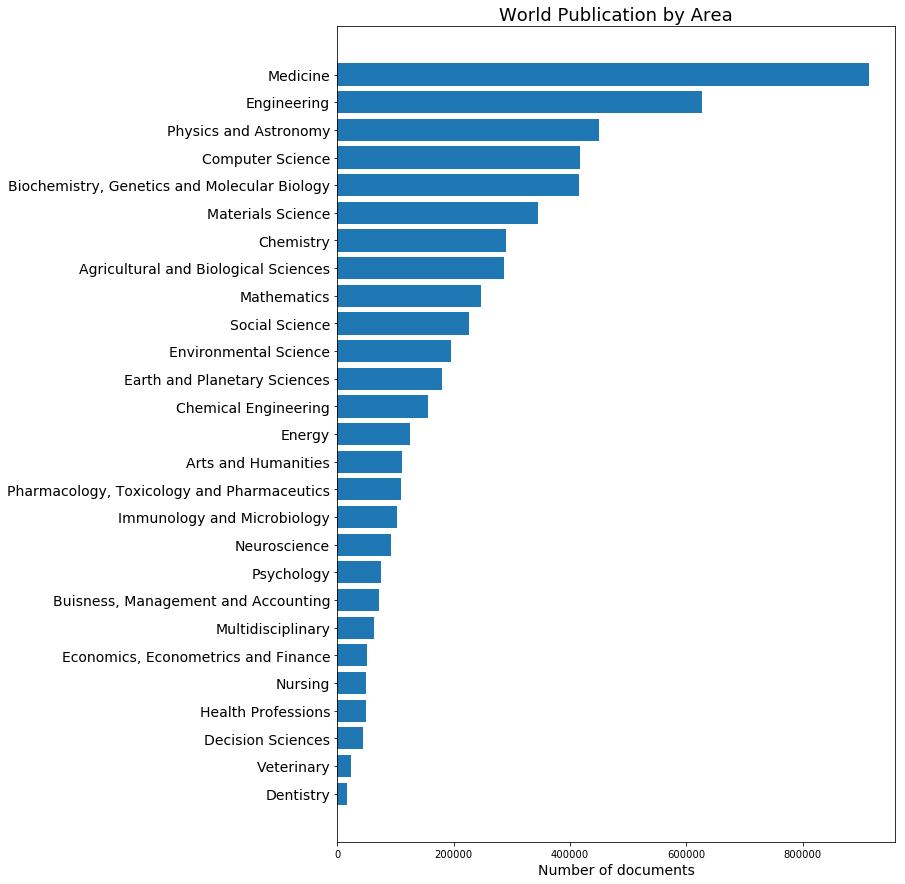

In [11]:
Pub1996 = SciPub.reset_index().loc[SciPub.reset_index()['Year']==1996]
Pub2016 = SciPub.reset_index().loc[SciPub.reset_index()['Year']==2016]

subplot(Pub1996,'Area','Documents')
subplot(Pub2016,'Area','Documents')

Over the past two decades, what is the trend of the number of publications in select areas

In [12]:
#define a function to plot the temporal trends of number of publications in certain groups(area or country)
def plottrend(dataset,index,value):
    annual = pd.pivot_table(dataset, values=[value], index=[index], aggfunc=np.sum)
    annual.sort_values(by=value,ascending=False,inplace=True)
    x_pos = [str(a) for a in range(1996,2017)]#display from year 1996 to 2017
    x_pos = sorted(x_pos, reverse=True)
    plt.plot(x_pos, annual.values, marker = 'o')
    plt.xlim(1994,2017)
    plt.ylim(ymin=0)
    plt.xlabel('Year',fontsize=12)
    plt.ylabel('Number of publication per year',fontsize=12)

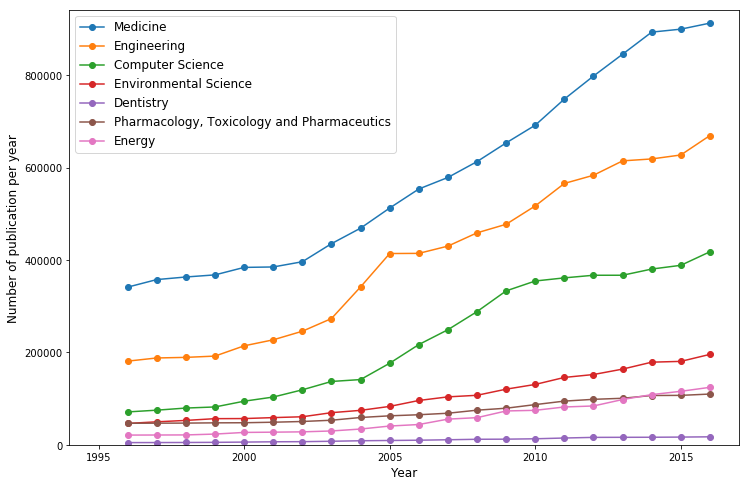

In [13]:
plot_area = [2700, 2200, 1700, 2300, 3500, 3000, 2100]

plt.figure(figsize=(12,8))
for area in plot_area: 
    plottrend(SciPub.loc[area],'Year','Documents')
plt.legend([area_dict[area] for area in plot_area],fontsize=12)
#plt.savefig('Trend.png')

How are the countries competing with each other?

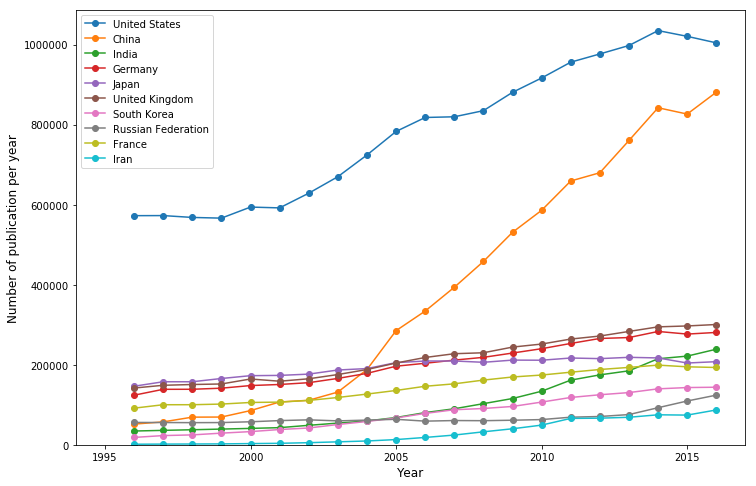

In [14]:
#plot the trend of total number of publications over time
country_byyr=pd.pivot_table(SciPub.reset_index(), values=['Documents'], index=['Country','Year'], aggfunc=np.sum)

countrylist = ['United States','China','India','Germany','Japan','United Kingdom','South Korea','Russian Federation','France','Iran']

plt.figure(figsize = (12,8))
x_pos = [str(a) for a in range(1996,2017)]
x_pos = sorted(x_pos, reverse=False)
for country in countrylist:
    plt.plot(x_pos, country_byyr.loc[country],marker = 'o')
plt.xlim(1994,2017)
plt.ylim(ymin=0)
plt.xlabel('Year',fontsize=12)
plt.ylabel('Number of publication per year',fontsize=12)
plt.legend(countrylist)

Let's use a table to explore the country ranking of publications in a certain area

In [15]:
#A function to rank the countries by variables such as number of publications, citations etc.
def rank_year(dataset, area, year,variable, total = 20):
    result = dataset.loc[area,year,:].sort_values(by=variable, ascending=False)
    result = result.reset_index()
    result = pd.DataFrame(result['Country'])
    result.columns = [year]
    result.index = result.index +1
    return result.head(total)

# a function that gives the rank over a range of years (in this analysis: maximum range is 2000 to 2016)
def rank(dataset, area, variable):
    year_list = input("Enter the year that you would like to explore: ")
    year_list = year_list.split(',')
    years = [rank_year(dataset,area,int(year),variable) for year in year_list]
    #years = [rank_year(dataset,area,year,variable) for year in range(int(year_start),int(year_end)+1)]
    comp = years[0].join(years[1:])
    return comp

In [16]:
rank(SciPub,1000,'Documents')#medicine

Enter the year that you would like to explore: 1996,2000,2004,2008,2012,2016


1996                2000                2004  \
1        United States       United States       United States   
2                China               China               China   
3       United Kingdom      United Kingdom  Russian Federation   
4              Germany             Germany      United Kingdom   
5                India               India               India   
6               France              France             Germany   
7                Japan               Japan               Japan   
8               Canada              Canada              France   
9   Russian Federation         Switzerland              Canada   
10         Switzerland           Australia              Brazil   
11           Australia               Italy         Switzerland   
12         Netherlands         Netherlands           Australia   
13               Italy  Russian Federation               Italy   
14              Sweden              Brazil         Netherlands   
15              Israel              Sweden               Spain   
16             Belgium              Israel              Sweden   
17              Brazil               Spain              Israel   
18               Spain             Belgium              Taiwan   
19             Austria              Taiwan             Belgium   
20             Denmark            Pakistan             Denmark   

              2008                2012                2016  
1    United States       United States               China  
2            China               China       United States  
3   United Kingdom      United Kingdom               India  
4            India                Iran      United Kingdom  
5          Germany               India             Germany  
6           France             Germany               Japan  
7            Japan            Malaysia         South Korea  
8           Canada              France              France  
9             Iran               Japan           Australia  
10           Italy               Egypt              Canada  
11       Australia              Canada               Italy  
12     Switzerland               Spain               Spain  
13          Brazil               Italy         Netherlands  
14           Spain         Switzerland  Russian Federation  
15        Malaysia           Australia         Switzerland  
16     Netherlands         Netherlands            Malaysia  
17          Sweden         South Korea              Taiwan  
18        Bulgaria              Brazil              Sweden  
19        Thailand            Thailand              Brazil  
20          Taiwan  Russian Federation           Singapore

In [17]:
#create a heatmap to visualize the share of publication by year
def heatmap(area):
    #select the desired area
    area_sub = SciPub.reset_index().loc[SciPub.reset_index()['Area']==int(area)]
    
    comp = pd.DataFrame()
    for year in range(1996,2017):
        temp = area_sub.loc[area_sub['Year']==year]
        total = temp['Documents'].sum()
        temp['DocumentsPercent'] = temp['Documents']/total
        comp = comp.append(temp)
    comp = comp[['Area','Year','Country','DocumentsPercent']]
    #
    heatmaplist = []
    top30 = comp['Country'].head(30).tolist()
    for country in top30:
        heatl = comp.loc[comp['Country']==country]['DocumentsPercent'].tolist()
        heatmaplist.append(heatl)
    
    fig, ax = plt.subplots()
    ypos = np.arange(30)
    xpos = np.arange(21)
    xlab = [x for x in range(1996,2017)]
    fig.set_size_inches(18,18)
    cax = ax.imshow(heatmaplist, cmap='hot', interpolation='nearest')
    ax.set_yticks(ypos)
    ax.set_yticklabels(top30,fontsize=12)
    ax.set_xticks(xpos)
    ax.set_xticklabels(xlab,rotation='vertical',fontsize=12)
    ax.set_xlabel('Year',fontsize=14)
    ax.set_title('Share of global publications in %s'%area_dict[area],fontsize=18)
    cbar = fig.colorbar(cax)
    plt.show()
    #plt.savefig('heatmap.png')

C:\Users\Li\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


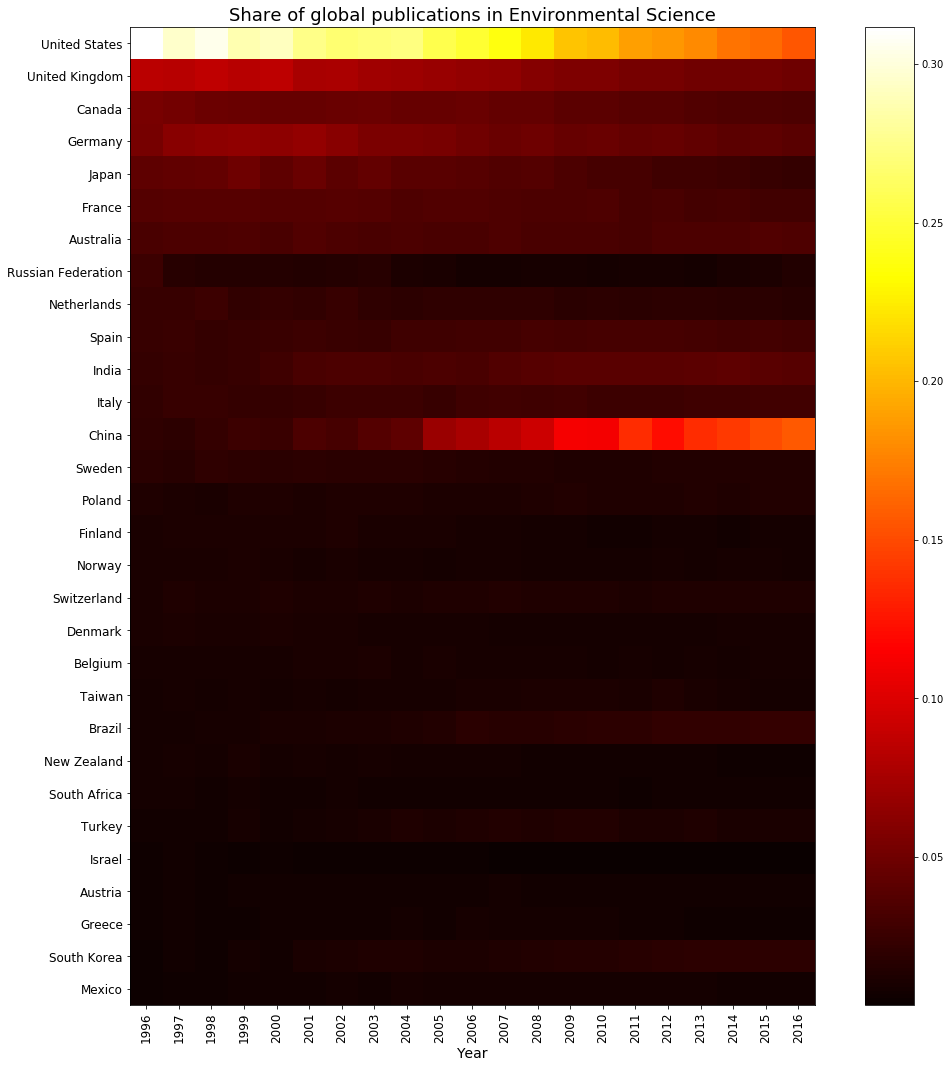

In [18]:
heatmap(2300)

Plot "shape of research" for each country.

To avoid the complexity of including countries with too few publications, only the countries with ranking among the top 30 in terms of their total number of publications during 1996-2016 were included

In [19]:
Top30 = SciPub_total.head(30)['Country'].tolist()

In [20]:
#Compile a dataset that stores the share of each area in the total publications for each country in each year
area_perc = pd.DataFrame()
for country in Top30:
    country_sub = SciPub.reset_index().loc[SciPub.reset_index()['Country']==country]
    for year in range(1996,2017):
        temp = country_sub.loc[country_sub['Year']==year]
        total = temp['Documents'].sum()
        temp['DocumentsPercent'] = temp['Documents']/total
        area_perc = area_perc.append(temp)
area_perc = area_perc[['Area','Year','Country','DocumentsPercent']]

C:\Users\Li\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [21]:
def PolarPlot(year, country):
    # Set data
    cat = []
    for key, value in area_dict.items():
        cat.append(value)
    values = area_perc.loc[(area_perc['Year']==year) & (area_perc['Country']==country)]
    values = values['DocumentsPercent'].tolist()

    N = len(cat)

    x_as = [n / float(N) * 2 * pi for n in range(N)]

    # Because our chart will be circular we need to append a copy of the first 
    # value of each list at the end of each list with data
    values += values[:1]
    x_as += x_as[:1]


    # Set color of axes
    plt.rc('axes', linewidth=1, edgecolor="black")

    figure(figsize=(10,10))
    # Create polar plot
    ax = plt.subplot(111, polar=True)


    # Set clockwise rotation.
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)


    # Set position of y-labels
    ax.set_rlabel_position(0)


    # Set color and linestyle of grid
    ax.xaxis.grid(True, color="#888888", linestyle='--', linewidth=0.5)
    ax.yaxis.grid(True, color="#888888", linestyle='--', linewidth=0.5)


    # Set number of radial axes and remove labels
    plt.xticks(x_as[:-1], [])

    # Set yticks
    plt.yticks([0.05, 0.1, 0.15, 0.20, 0.25], ["5%", "10%", "15%", "20%", "25%"])


    # Plot data
    ax.plot(x_as, values, linewidth=0, linestyle='solid', zorder=3)

    # Fill area
    ax.fill(x_as, values, 'grey', alpha=0.5)
    
    #Set a title
    ttl = ax.title
    ttl.set_text(country+' '+str(year))
    ttl.set_position([.5, 1.1])
    ttl.set_fontsize(20)

    # Set axes limits
    plt.ylim(0, 0.20)


    # Draw ytick labels to make sure they fit properly
    for i in range(N):
        angle_rad = i / float(N) * 2 * pi

        if angle_rad == 0:
            ha, distance_ax = "center", 0.21
        elif 0 < angle_rad < pi:
            ha, distance_ax = "left", 0.2
        elif angle_rad == pi:
            ha, distance_ax = "center", 0.2
        else:
            ha, distance_ax = "right", 0.2

        ax.text(angle_rad, distance_ax+0.01, cat[i], size=12, horizontalalignment=ha, verticalalignment="center")


    # Show polar plot
    #plt.show()
    
    #save plot
    plt.savefig('Polar%s%s.png'%(country,year), bbox_inches="tight")

C:\Users\Li\Anaconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


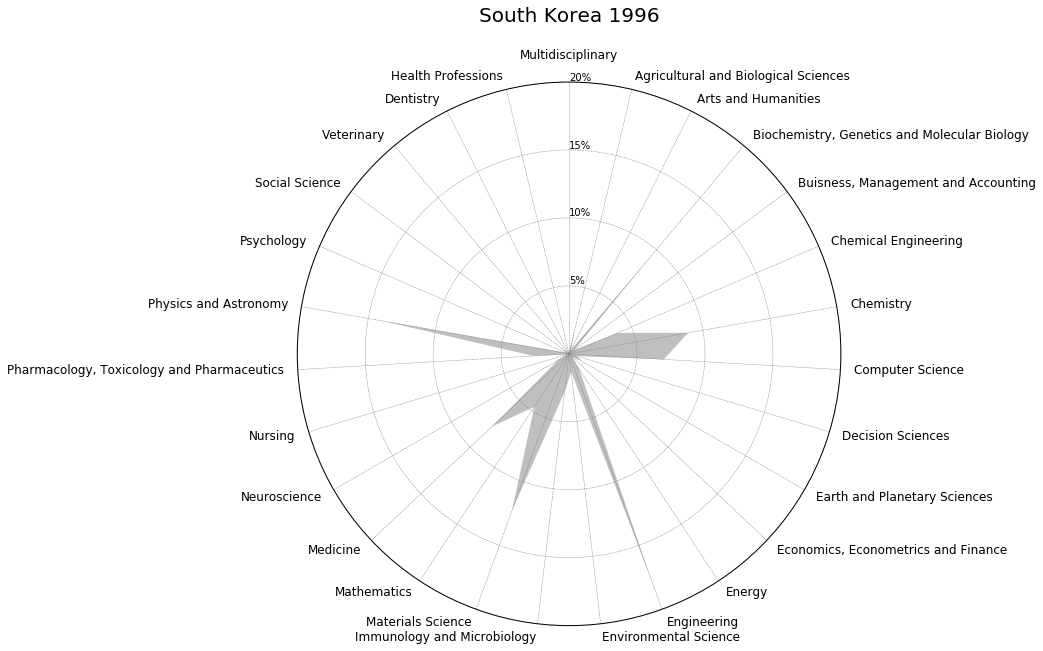

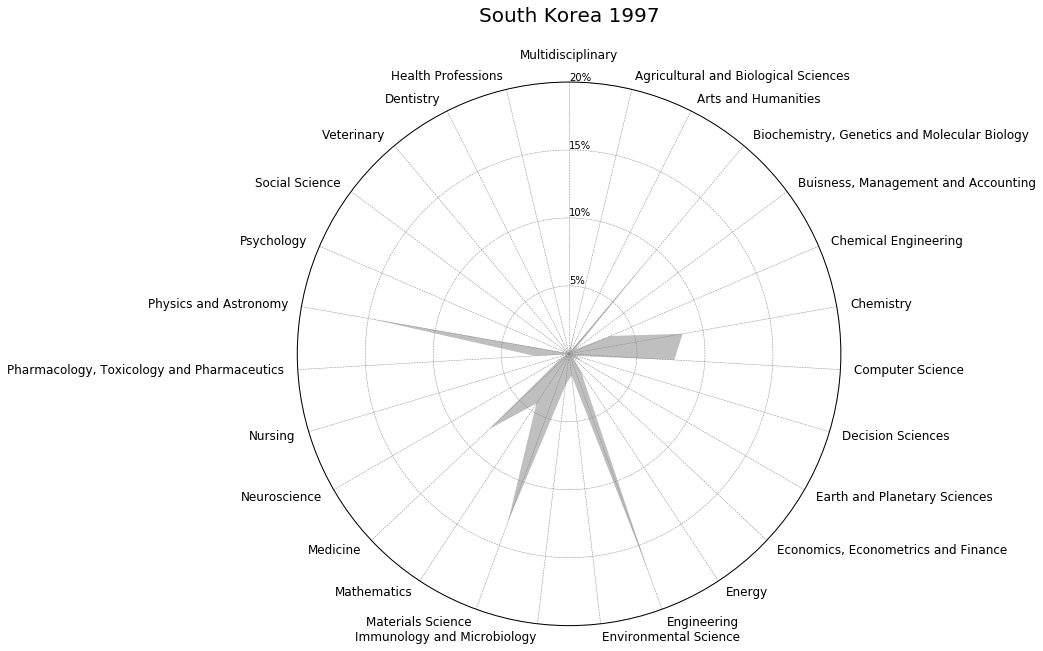

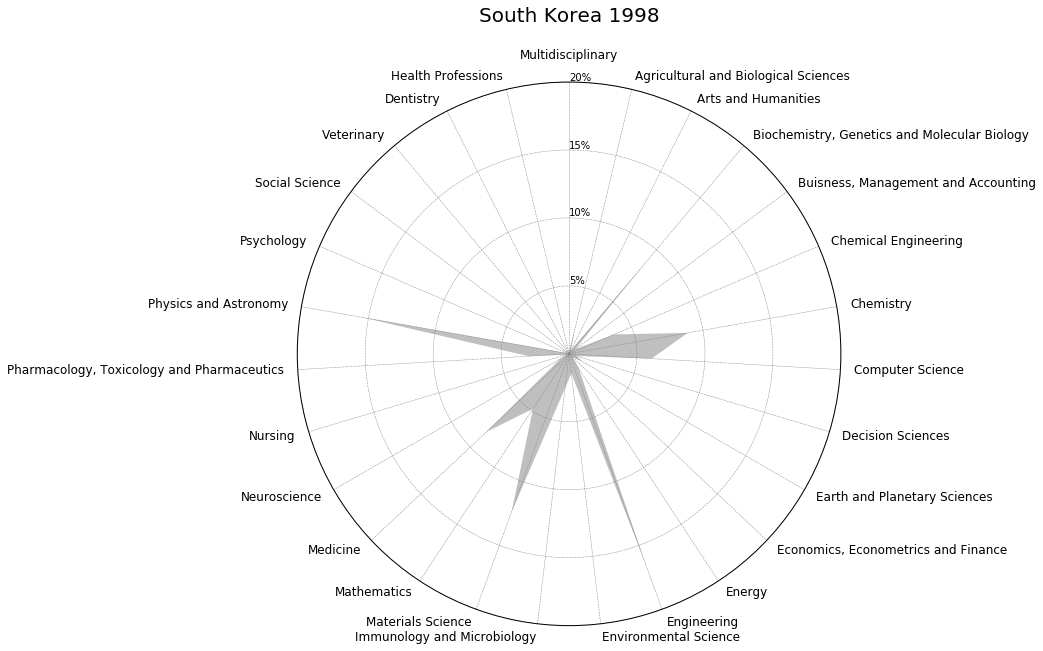

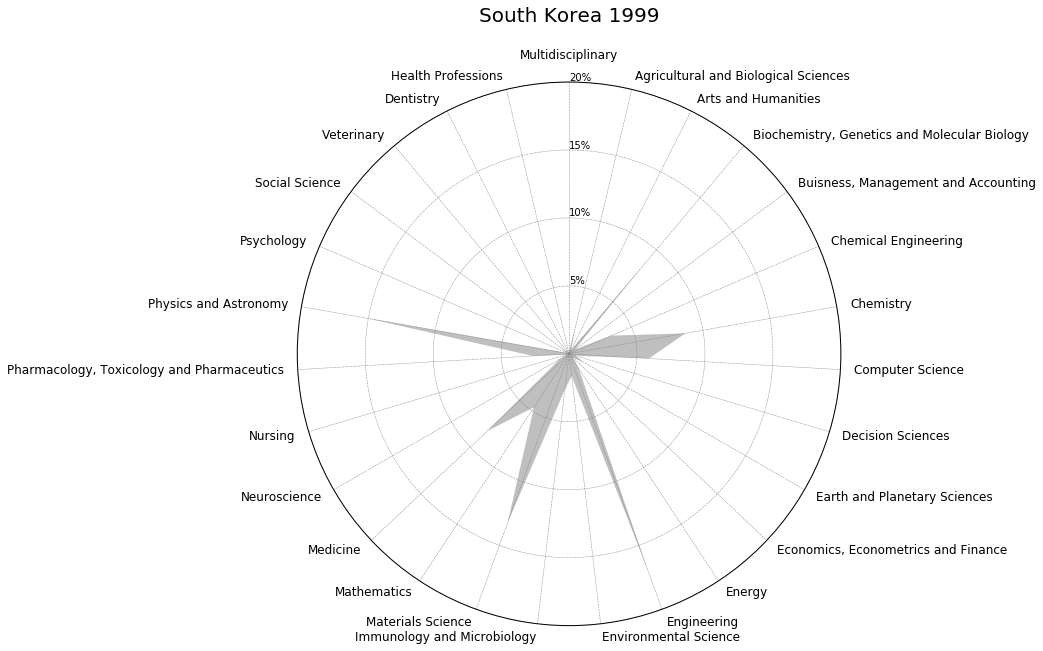

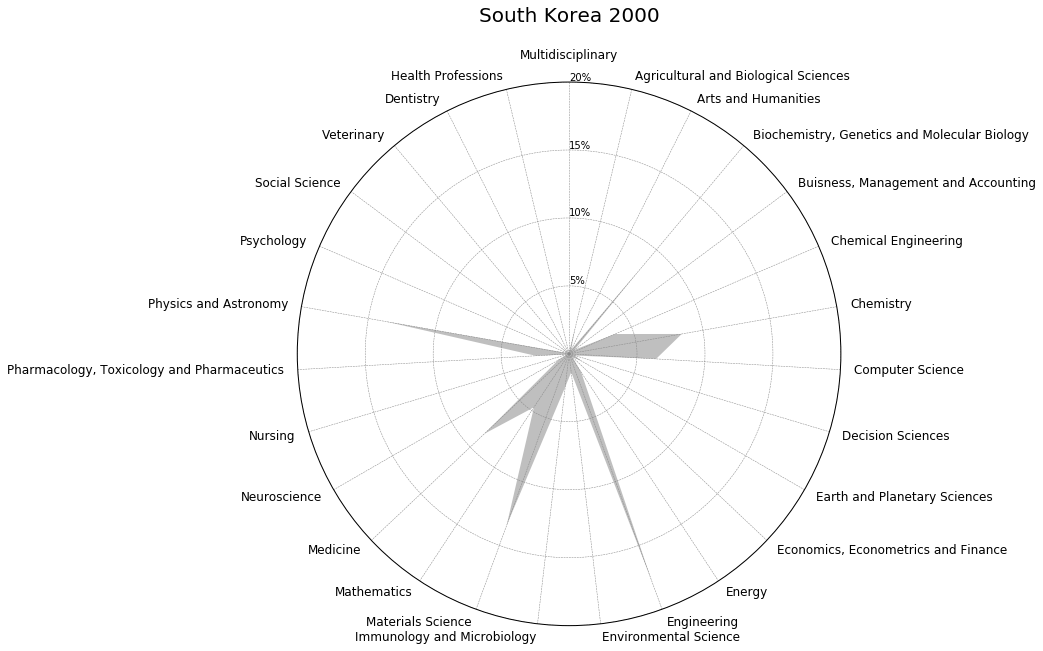

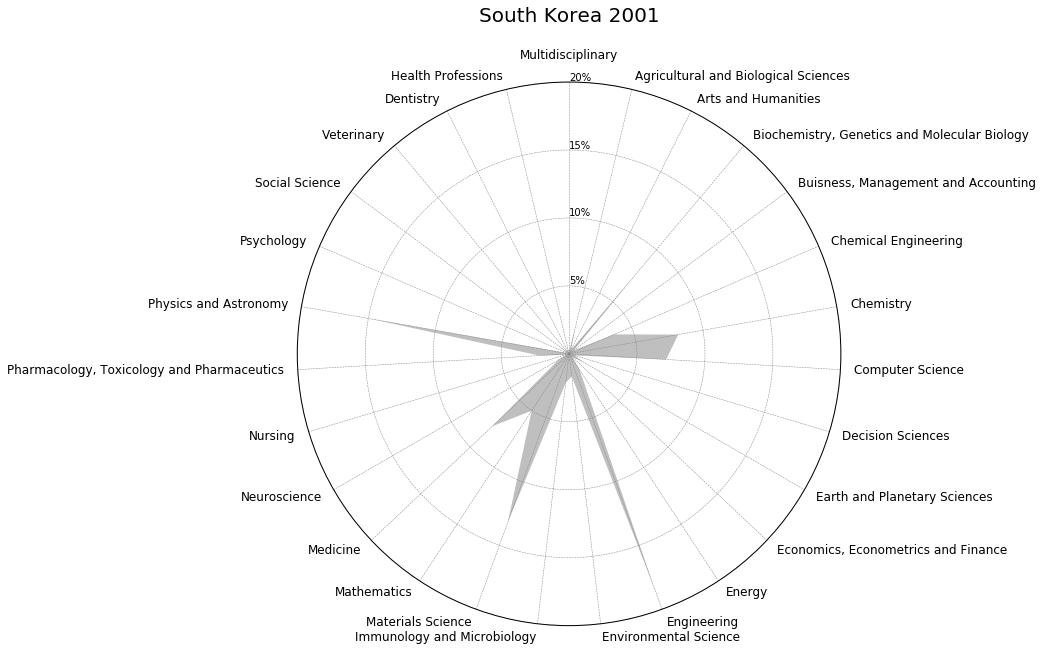

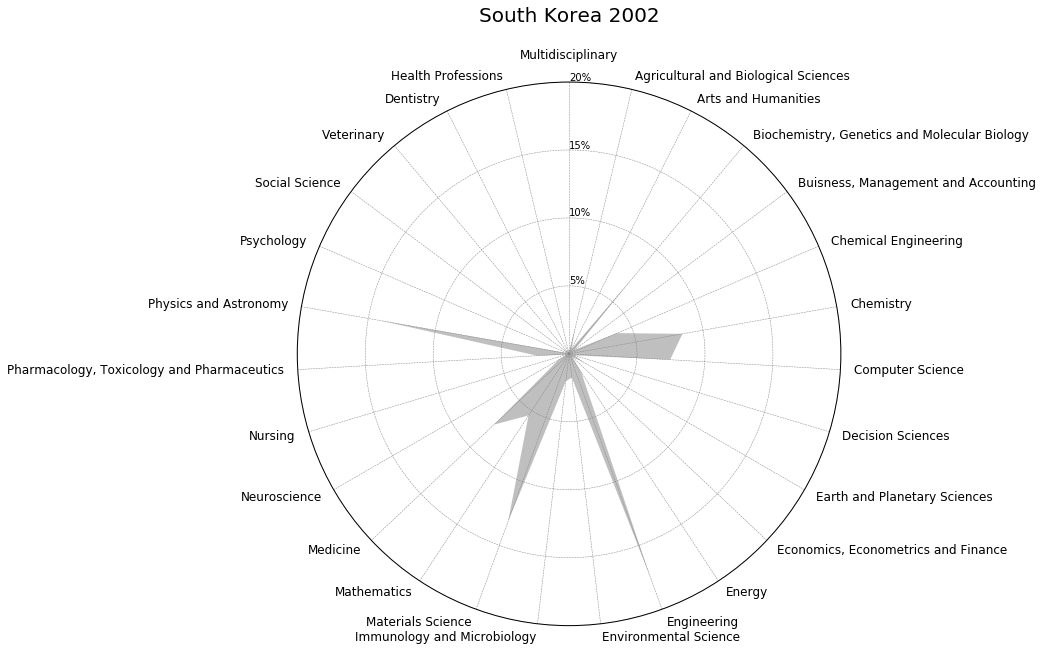

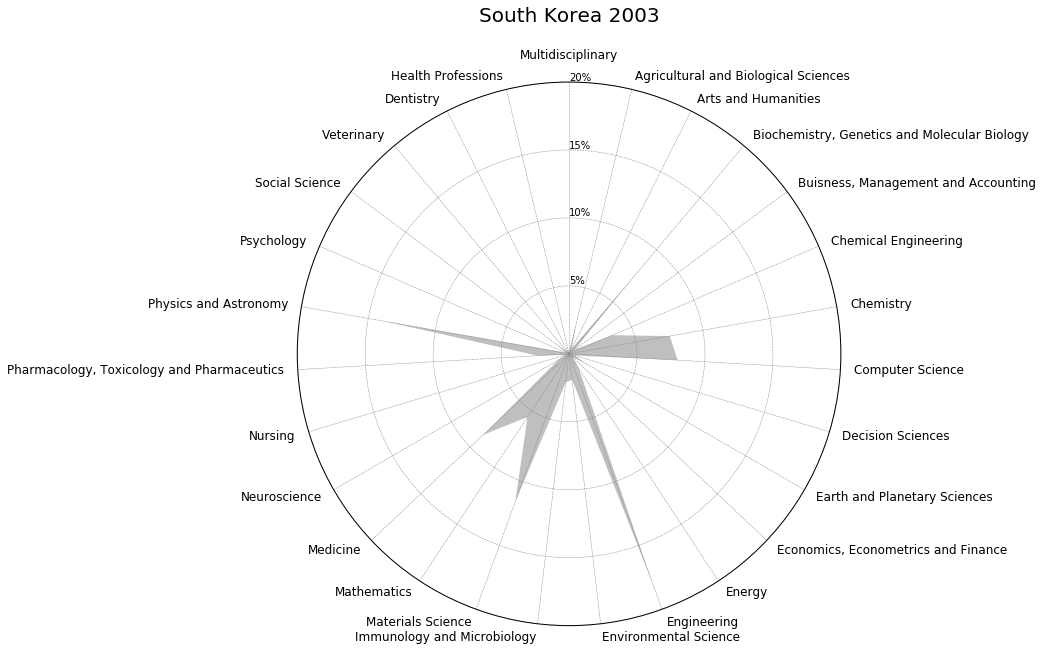

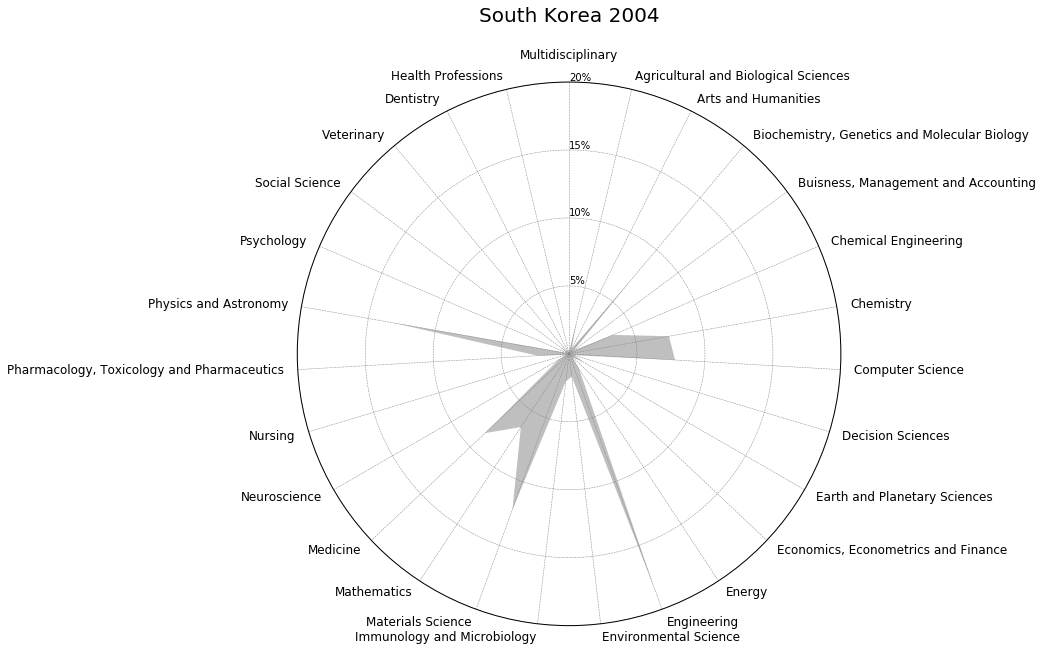

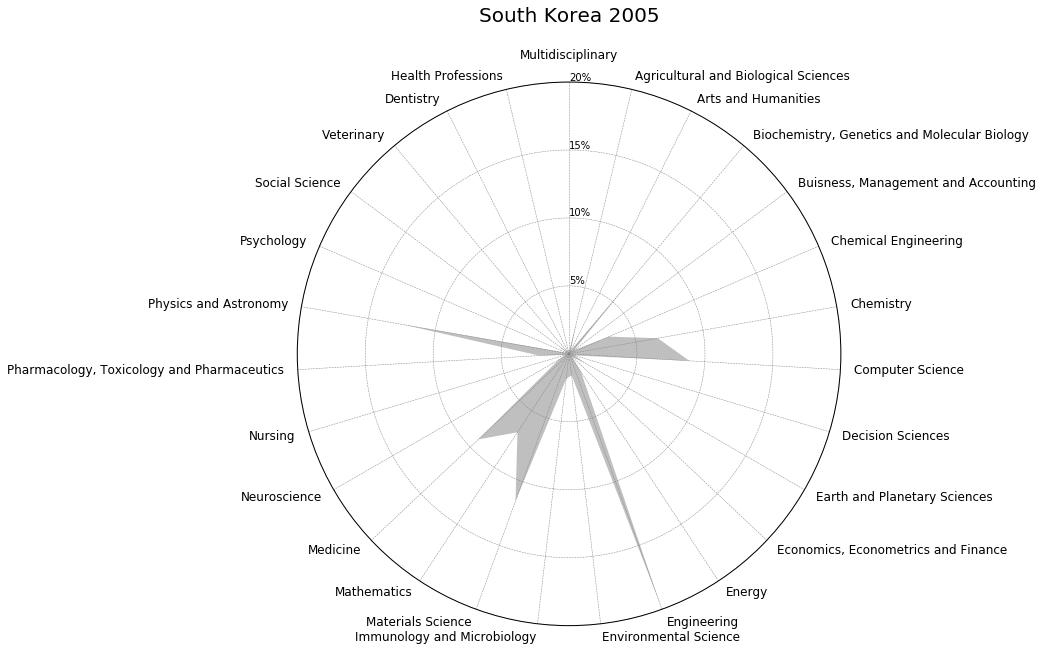

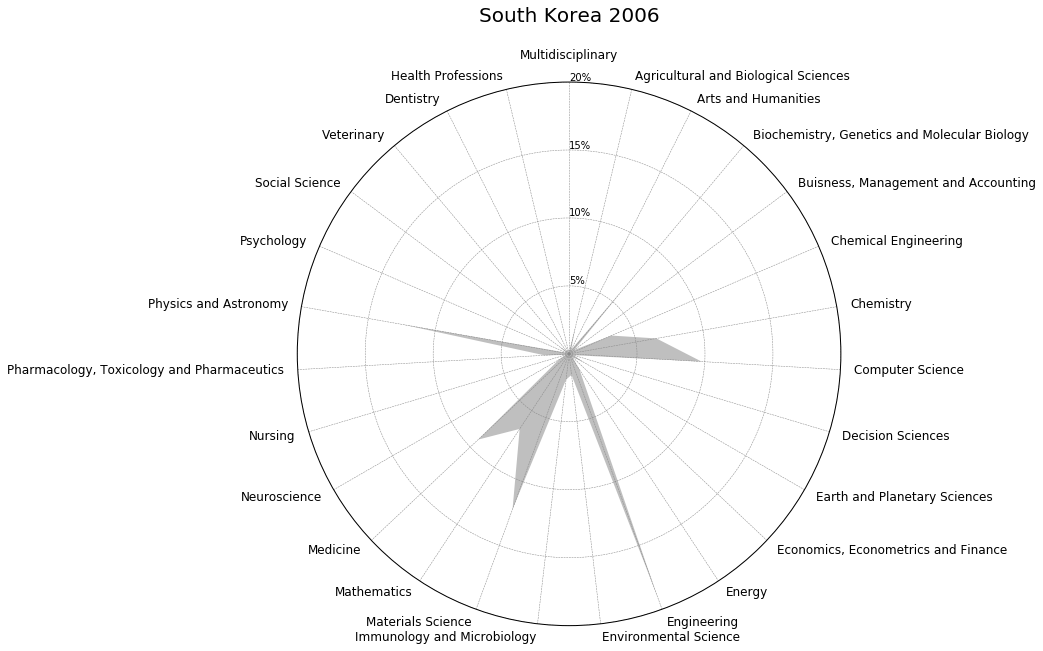

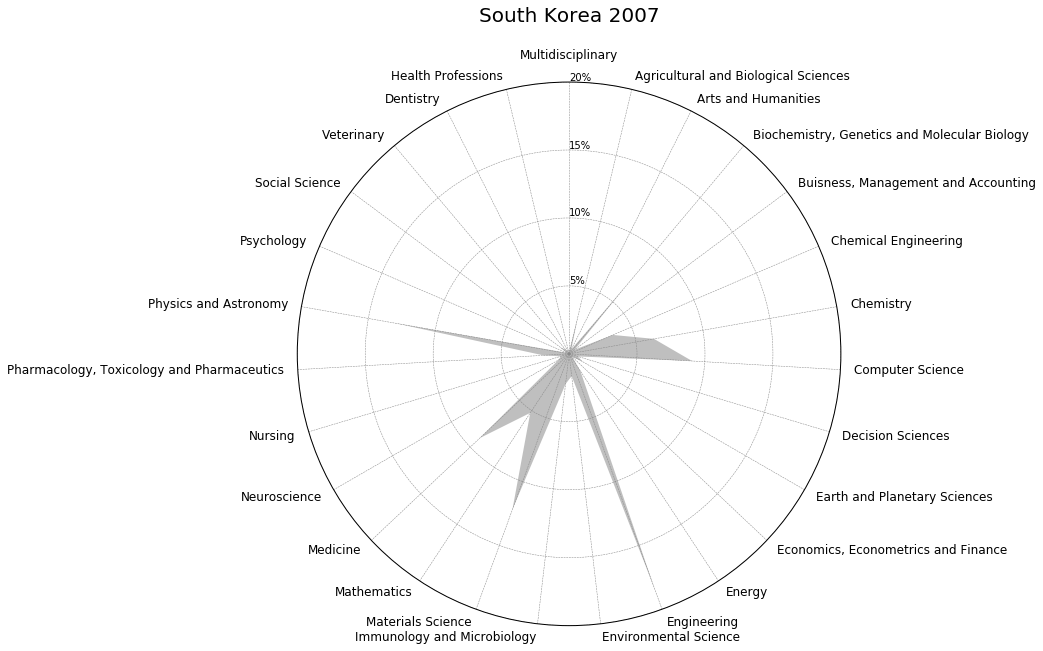

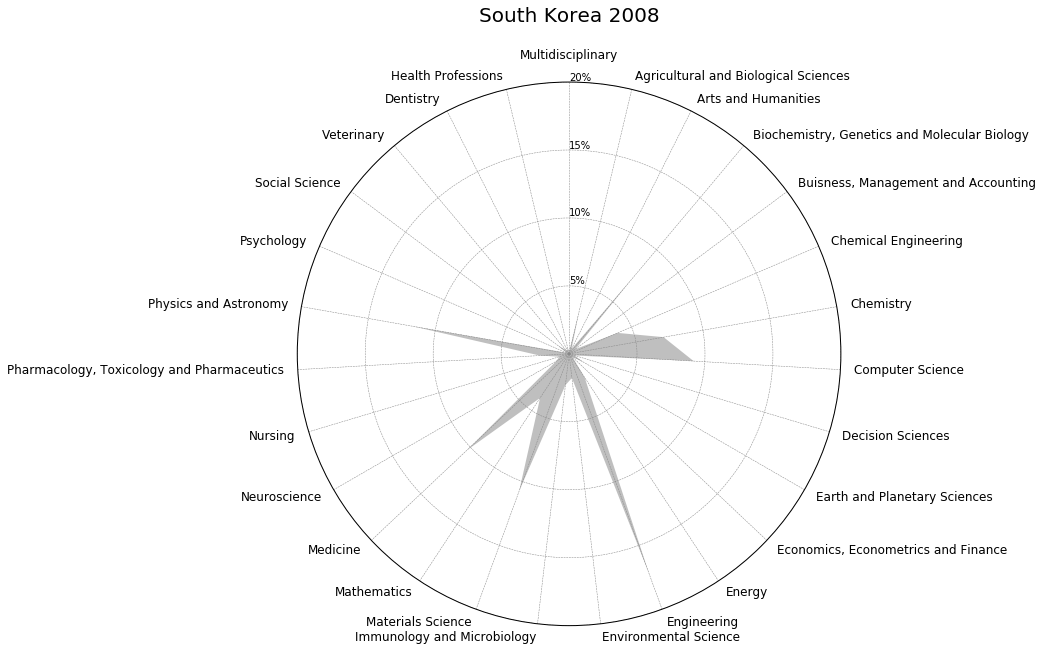

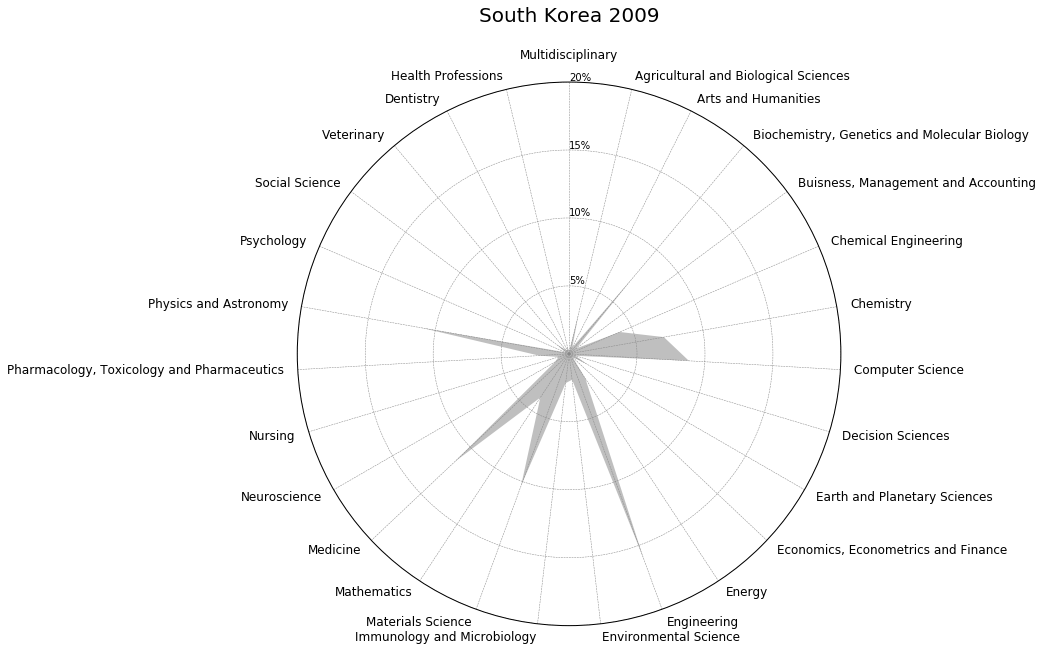

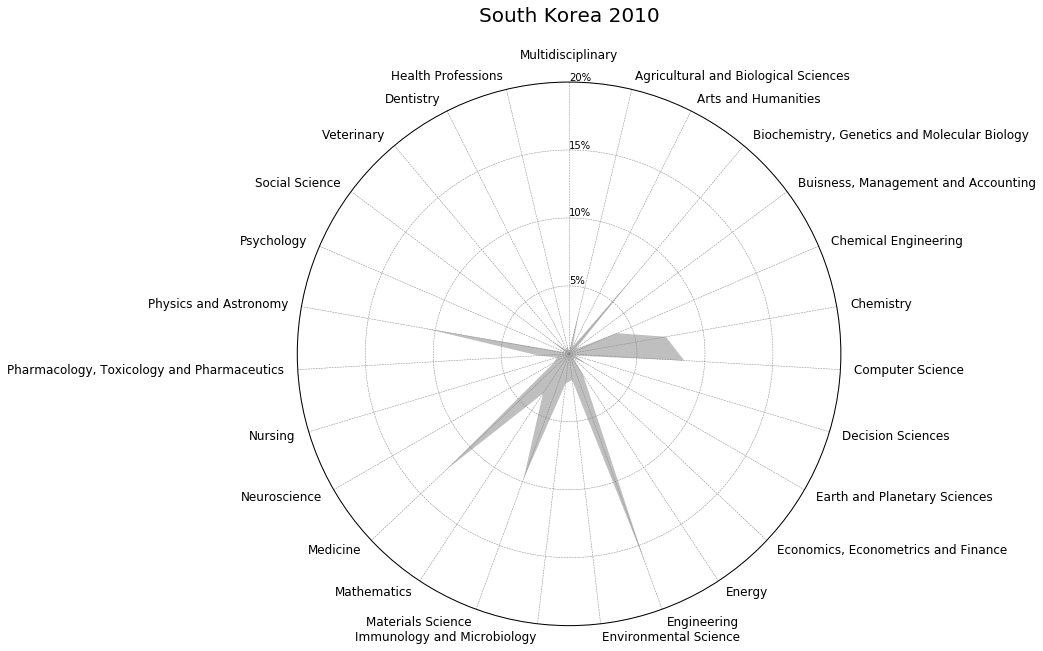

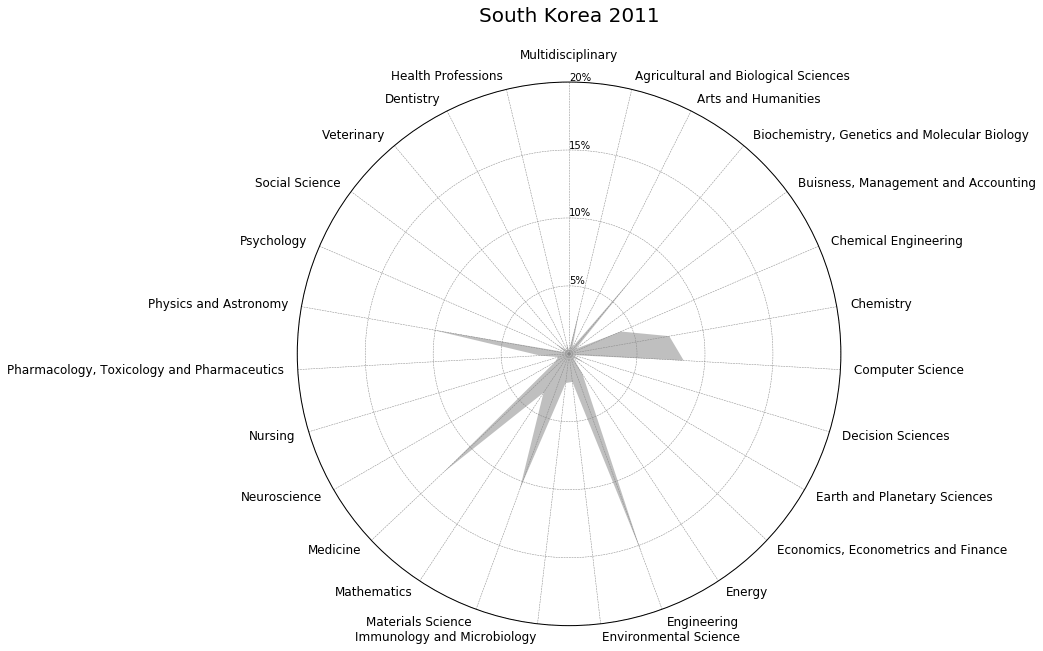

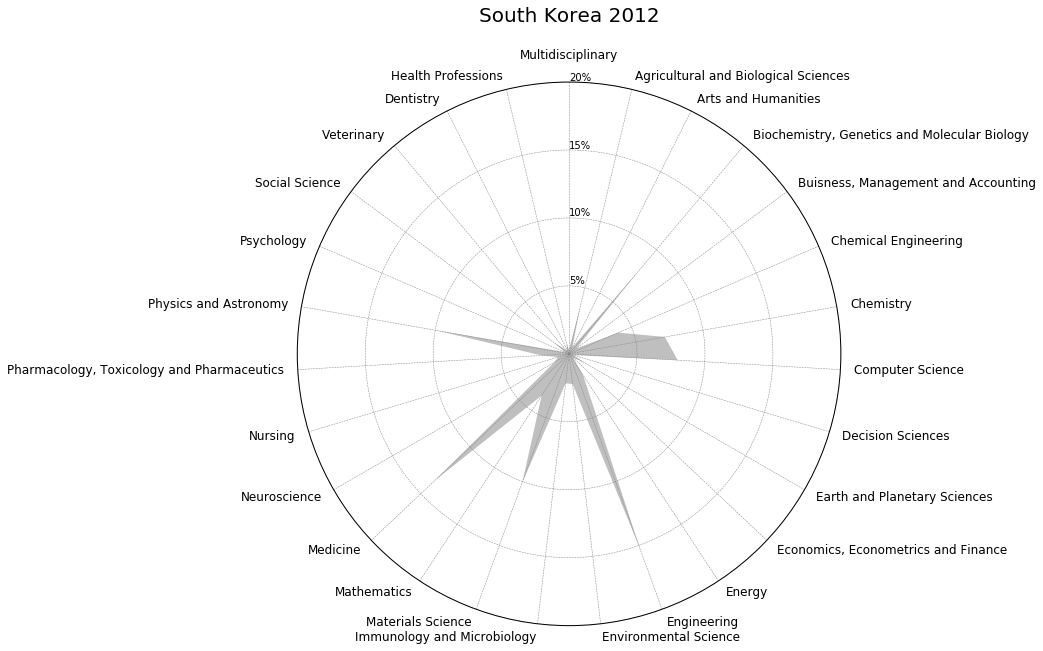

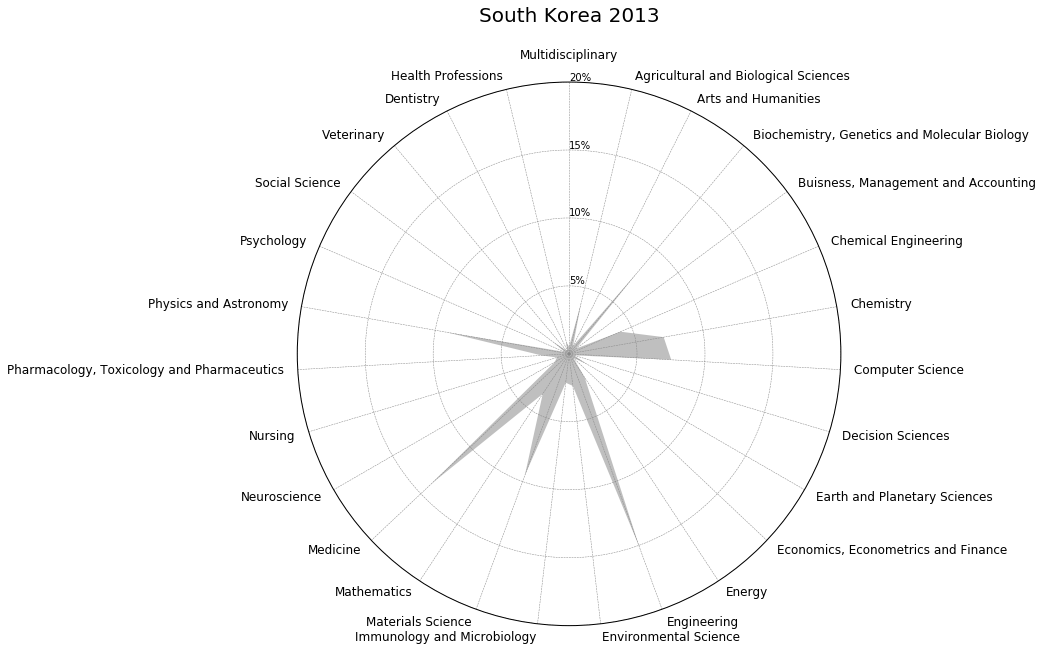

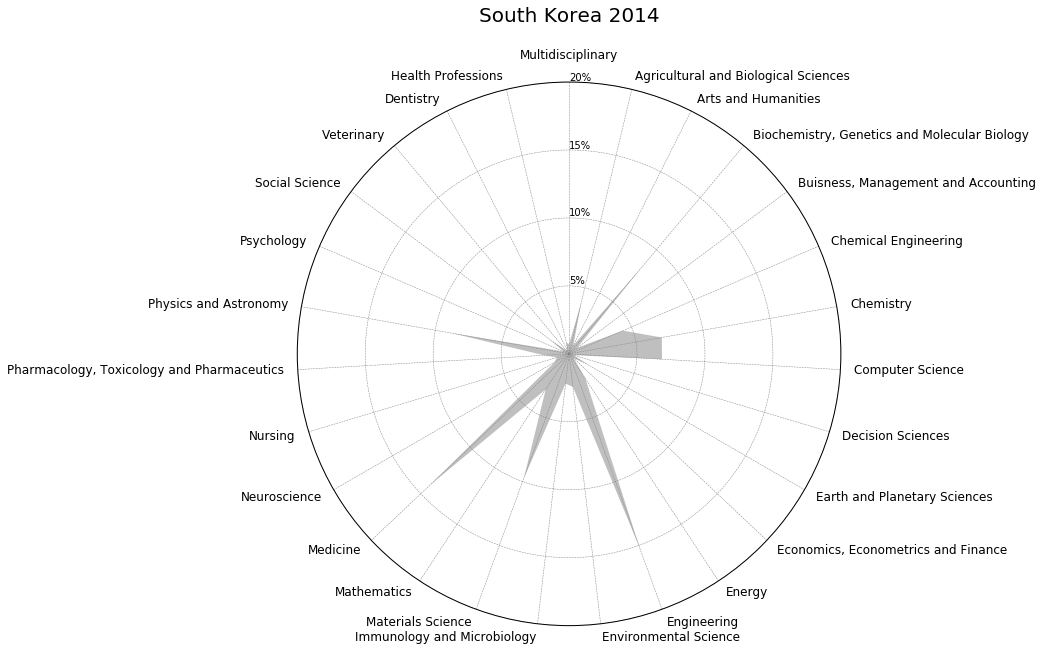

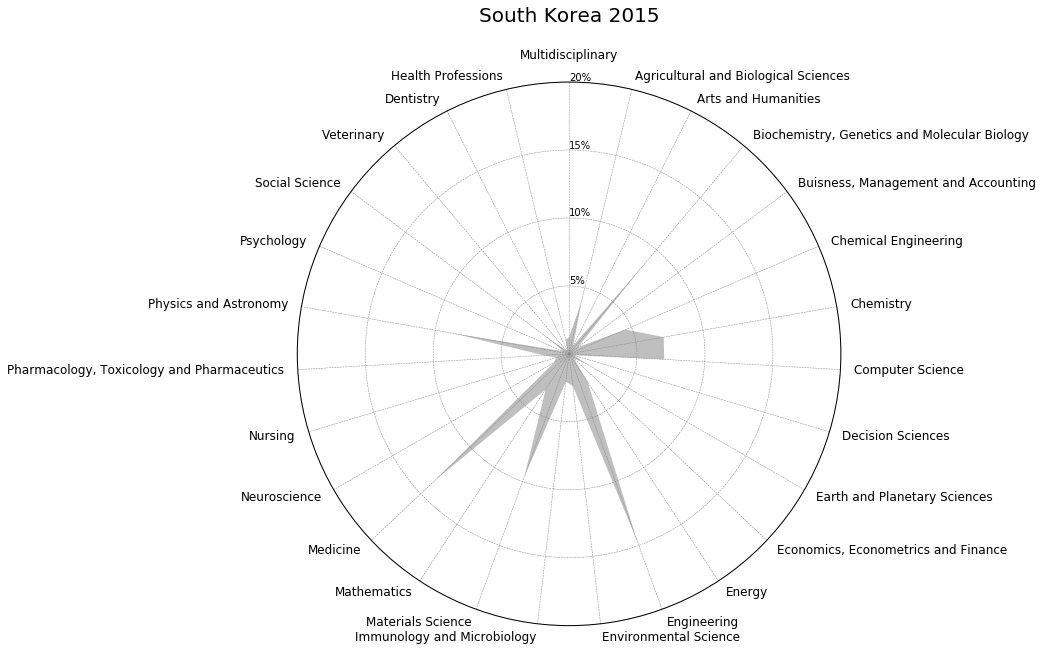

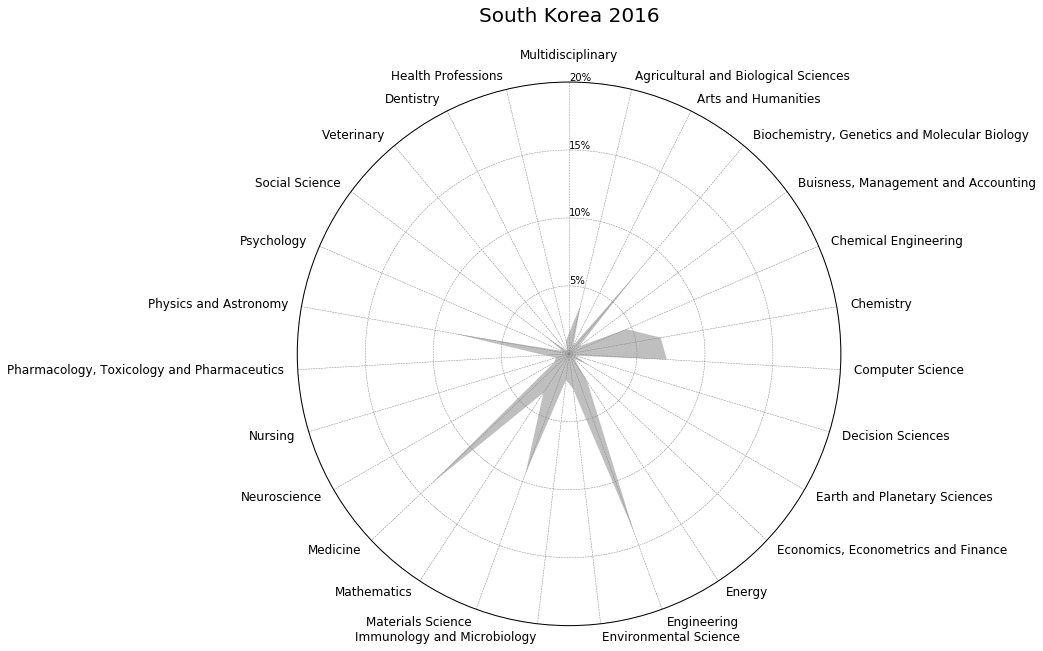

In [715]:
#automatically save and display the polar plots for each in during 1996 and 2017
for year in range(1996,2017):
    PolarPlot(year,'South Korea')

Where are the major increase of research outcomes are in relative sense?

In order further rule out the complexity caused by certain countries that did not have publications in all of the 27 fields, only the top 20 (ranked by total number of publications) countreis are included here.

In [22]:
#Compile a dataset that stores the relative increase of number of publications in each area for each country
Ratio = pd.DataFrame()
for country in Top30[:21]:#only focus on the top 20 countries since some countries do not have publications in all areas 1996
    buff = pd.DataFrame()
    Pub1996 = SciPub.reset_index().loc[(SciPub.reset_index()['Year']==1996) & (SciPub.reset_index()['Country']==country)]
    Pub2016 = SciPub.reset_index().loc[(SciPub.reset_index()['Year']==2016) & (SciPub.reset_index()['Country']==country)]
    RatioList = (Pub2016['Documents'].values/Pub1996['Documents'].values).tolist()
    buff = buff.append(RatioList)
    buff.insert(0,'Country', [country]*len(buff))
    buff.insert(0,'Area', [k for k,v in area_dict.items()])
    buff.columns = ['Area','Country','Ratio']
    Ratio = Ratio.append(buff)
    
#calculate the median relative increase of top20 countries to identify where the globaly growth of research interests are
WorldRatio = pd.DataFrame()
for country in Top30[:21]:
    buff = Ratio.loc[Ratio['Country']==country]
    WorldRatio = pd.concat([WorldRatio, pd.DataFrame(buff['Ratio'].values.tolist())],axis=1)
WorldRatio.columns = Top30[:21]
WorldRatio.insert(0,'Country', ['World']*len(WorldRatio))
WorldRatio.insert(0,'Area', [k for k,v in area_dict.items()])    
WorldRatio['Ratio'] = WorldRatio.median(axis=1).tolist()
WorldRatio = WorldRatio[['Area','Country','Ratio']]

#consolidate this into Ratio dataset. When plotting, use "World" as the area argument.
Ratio = Ratio.append(WorldRatio)

In [23]:
#define a modified function to make polar plots for (publications in 2016/publications in 1996)
def PolarPlot2(values, country, ylimit):#ylimit is used to adjust the scale for radial axis
    # Set data
    cat = []
    for key, value in area_dict.items():
        cat.append(value)
    values = Ratio.loc[Ratio['Country']==country]
    values = values['Ratio'].tolist()

    N = len(cat)

    x_as = [n / float(N) * 2 * pi for n in range(N)]

    # Because our chart will be circular we need to append a copy of the first 
    # value of each list at the end of each list with data
    values += values[:1]
    x_as += x_as[:1]


    # Set color of axes
    plt.rc('axes', linewidth=1, edgecolor="black")

    plt.figure(figsize=(10,10))
    # Create polar plot
    ax = plt.subplot(111, polar=True)


    # Set clockwise rotation.
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)


    # Set position of y-labels
    ax.set_rlabel_position(0)


    # Set color and linestyle of grid
    ax.xaxis.grid(True, color="#888888", linestyle='--', linewidth=0.5)
    ax.yaxis.grid(True, color="#888888", linestyle='--', linewidth=0.5)


    # Set number of radial axes and remove labels
    plt.xticks(x_as[:-1], [])

    # Set yticks
    #plt.yticks([0.05, 0.1, 0.15, 0.20, 0.25], ["5%", "10%", "15%", "20%", "25%"])


    # Plot data
    ax.plot(x_as, values, linewidth=0, linestyle='solid', zorder=3)

    # Fill area
    ax.fill(x_as, values, 'grey', alpha=0.5)
    
    #Set a title
    ttl = ax.title
    ttl.set_text(country)
    ttl.set_position([.5, 1.1])
    ttl.set_fontsize(20)

    # Set axes limits
    plt.ylim(0, ylimit)


    # Draw ytick labels to make sure they fit properly
    for i in range(N):
        angle_rad = i / float(N) * 2 * pi

        if angle_rad == 0:
            ha, distance_ax = "center", ylimit+0.05*ylimit#this margin was determined by trial and error
        elif 0 < angle_rad < pi:
            ha, distance_ax = "left", ylimit
        elif angle_rad == pi:
            ha, distance_ax = "center", ylimit
        else:
            ha, distance_ax = "right", ylimit

        ax.text(angle_rad, distance_ax+0.05*ylimit, cat[i], size=12, horizontalalignment=ha, verticalalignment="center")


    # Show polar plot
    #plt.show()
    
    #save plot
    #plt.savefig('Polar%s%s.png'%(country,year), bbox_inches="tight")

In [29]:
# It is recommended to always check the maximum value of field to be plotted
max(Ratio.loc[Ratio['Country']=='World']['Ratio'])

11.242659883720929

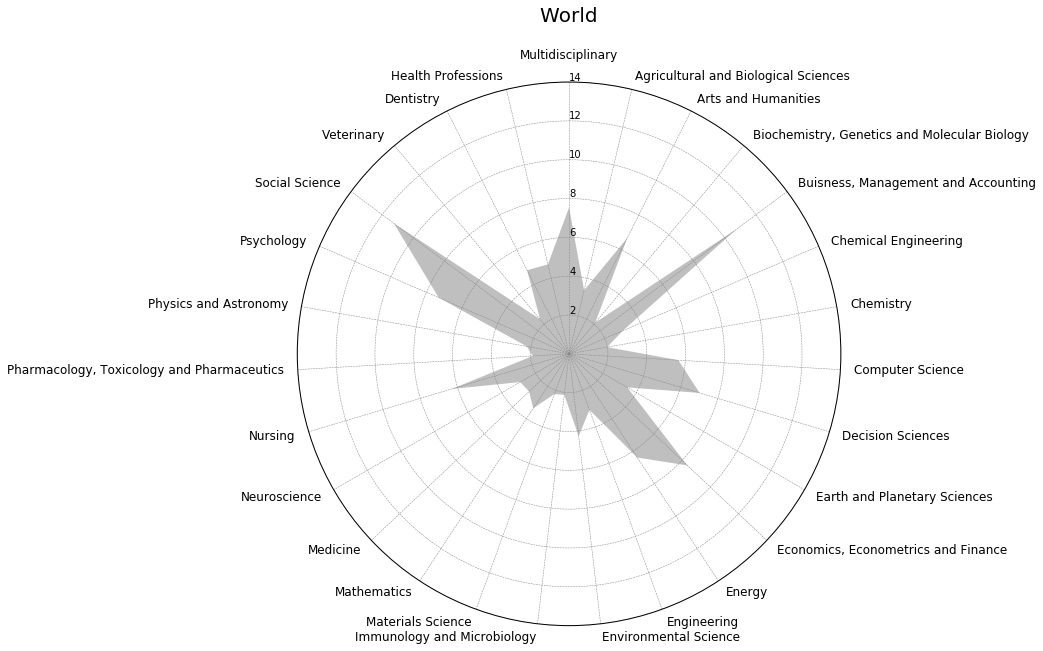

In [30]:
#make polar plots and adjust the scale of radial axis based on the maximum value generated from previous cell
PolarPlot2(Ratio, 'World',14)